# LIME Explanation for Image Classification

This notebook demonstrates the use of LIME (Local Interpretable Model-agnostic Explanations) to interpret image classification predictions.

In [1]:

# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image  # Add PIL for image conversion
import cv2  # Add OpenCV for additional image processing
from tensorflow.keras.models import load_model
from preprocessing.patch_generator import smash_n_reconstruct
from classification import preprocess_single_image
from keras import layers, saving


c:\Users\esull\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\esull\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'feature_extraction_layer_rich_texture', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\esull\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'feature_extraction_layer_poor_texture', however the layer does not have a `build()` method im


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
Prediction: AI-generated image with 50.71% confidence


In [9]:

def ensure_rgb_image(image_path):
    """
    Ensure the image is converted to RGB format
    """
    # Read image with OpenCV
    img = cv2.imread(image_path)
    
    # If image is grayscale, convert to RGB
    if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # If image is in BGR (OpenCV default), convert to RGB
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img


In [15]:
from skimage.transform import resize

def explain_prediction_lime(model, image_path):
    """
    Generate and visualize LIME explanations for a single image prediction.
    """
    # Preprocess the test image
    test_image = preprocess_single_image(image_path)
    test_data = [
        np.expand_dims(test_image['rich_texture'], axis=0),  # First input
        np.expand_dims(test_image['poor_texture'], axis=0)   # Second input
    ]
    
    # Convert original image to RGB
    original_image = ensure_rgb_image(image_path)
    
    # Wrapper function for model prediction
    def model_predict_wrapper(images):
        # Convert images to match model's expected input
        images_rich = images[:, :, :, 0:1]  # Extract rich texture channel
        images_poor = images[:, :, :, 1:2]  # Extract poor texture channel
        return model.predict([images_rich, images_poor])
    
    # Prepare image for LIME
    lime_image_data = np.stack([
        test_data[0].squeeze(),  # Rich texture
        test_data[1].squeeze(),  # Poor texture
        np.zeros_like(test_data[0].squeeze())  # Placeholder for third channel
    ], axis=-1)
    
    # Initialize the LimeImageExplainer
    explainer = lime_image.LimeImageExplainer()
    
    # Get explanation for the image
    explanation = explainer.explain_instance(
        image=lime_image_data,
        classifier_fn=model_predict_wrapper,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )
    
    # Select the top predicted label
    label_to_visualize = explanation.top_labels[0]
    
    # Create the explanation visualization
    temp, mask = explanation.get_image_and_mask(
        label=label_to_visualize,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    
    # Resize the mask to match the original image dimensions
    resized_mask = resize(mask, original_image.shape[:2], preserve_range=True, anti_aliasing=True)
    resized_mask = resized_mask.astype(bool)  # Ensure mask is boolean

    # Plot the original images with LIME explanation overlay
    plt.figure(figsize=(15, 5))
    
    # Original rich texture
    plt.subplot(1, 3, 1)
    plt.title('Original Rich Texture')
    plt.imshow(test_data[0][0, :, :, 0], cmap='gray')
    plt.axis('off')
    
    # Original poor texture
    plt.subplot(1, 3, 2)
    plt.title('Original Poor Texture')
    plt.imshow(test_data[1][0, :, :, 0], cmap='gray')
    plt.axis('off')
    
    # LIME explanation overlay
    plt.subplot(1, 3, 3)
    plt.title(f'LIME Explanation (Label {label_to_visualize})')
    lime_overlay = mark_boundaries(original_image / 255.0, resized_mask, color=(1, 0, 0))
    plt.imshow(lime_overlay)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Model prediction
    prediction = model.predict(test_data)
    return label_to_visualize, prediction[0][0]


## Example Usage
Load your model and test an image with the LIME explanation function.

c:\Users\esull\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'feature_extraction_layer_rich_texture', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\esull\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'feature_extraction_layer_poor_texture', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
  0%|          | 0/1000 [00:00<?, ?it/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


  1%|          | 10/1000 [00:01<01:45,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


  2%|▏         | 20/1000 [00:01<01:20, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


  3%|▎         | 30/1000 [00:02<01:13, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


  4%|▍         | 40/1000 [00:03<01:09, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


  5%|▌         | 50/1000 [00:03<01:06, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


  6%|▌         | 60/1000 [00:04<01:04, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


  7%|▋         | 70/1000 [00:05<01:05, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


  8%|▊         | 80/1000 [00:05<01:03, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


  9%|▉         | 90/1000 [00:06<01:03, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 10%|█         | 100/1000 [00:07<01:03, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 11%|█         | 110/1000 [00:07<01:02, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 12%|█▏        | 120/1000 [00:08<01:00, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 13%|█▎        | 130/1000 [00:09<01:00, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 14%|█▍        | 140/1000 [00:09<00:59, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 15%|█▌        | 150/1000 [00:10<00:58, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 16%|█▌        | 160/1000 [00:11<00:58, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 17%|█▋        | 170/1000 [00:12<00:58, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 18%|█▊        | 180/1000 [00:12<00:57, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 19%|█▉        | 190/1000 [00:13<00:56, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 20%|██        | 200/1000 [00:14<00:55, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 21%|██        | 210/1000 [00:14<00:54, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 22%|██▏       | 220/1000 [00:15<00:53, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 23%|██▎       | 230/1000 [00:16<00:52, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 24%|██▍       | 240/1000 [00:16<00:51, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 25%|██▌       | 250/1000 [00:17<00:51, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 26%|██▌       | 260/1000 [00:18<00:50, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 27%|██▋       | 270/1000 [00:18<00:49, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 28%|██▊       | 280/1000 [00:19<00:49, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 29%|██▉       | 290/1000 [00:20<00:48, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 30%|███       | 300/1000 [00:20<00:48, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 31%|███       | 310/1000 [00:21<00:47, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 32%|███▏      | 320/1000 [00:22<00:46, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 33%|███▎      | 330/1000 [00:23<00:46, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 34%|███▍      | 340/1000 [00:23<00:45, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 35%|███▌      | 350/1000 [00:24<00:44, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 36%|███▌      | 360/1000 [00:25<00:43, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 37%|███▋      | 370/1000 [00:25<00:43, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 38%|███▊      | 380/1000 [00:26<00:42, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 39%|███▉      | 390/1000 [00:27<00:42, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 40%|████      | 400/1000 [00:27<00:41, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 41%|████      | 410/1000 [00:28<00:40, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 42%|████▏     | 420/1000 [00:29<00:40, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 43%|████▎     | 430/1000 [00:29<00:40, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 44%|████▍     | 440/1000 [00:30<00:39, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 45%|████▌     | 450/1000 [00:31<00:38, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 46%|████▌     | 460/1000 [00:32<00:37, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 47%|████▋     | 470/1000 [00:32<00:37, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 48%|████▊     | 480/1000 [00:33<00:36, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 49%|████▉     | 490/1000 [00:34<00:35, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 50%|█████     | 500/1000 [00:34<00:34, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 51%|█████     | 510/1000 [00:35<00:34, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 52%|█████▏    | 520/1000 [00:36<00:34, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 53%|█████▎    | 530/1000 [00:37<00:33, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 54%|█████▍    | 540/1000 [00:37<00:32, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 55%|█████▌    | 550/1000 [00:38<00:31, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 56%|█████▌    | 560/1000 [00:39<00:31, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 57%|█████▋    | 570/1000 [00:39<00:32, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 58%|█████▊    | 580/1000 [00:40<00:31, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 59%|█████▉    | 590/1000 [00:41<00:31, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 60%|██████    | 600/1000 [00:42<00:31, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 61%|██████    | 610/1000 [00:43<00:30, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 62%|██████▏   | 620/1000 [00:43<00:29, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 63%|██████▎   | 630/1000 [00:44<00:28, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 64%|██████▍   | 640/1000 [00:45<00:26, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 65%|██████▌   | 650/1000 [00:46<00:25, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 66%|██████▌   | 660/1000 [00:46<00:24, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 67%|██████▋   | 670/1000 [00:47<00:23, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 68%|██████▊   | 680/1000 [00:48<00:22, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 69%|██████▉   | 690/1000 [00:48<00:22, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 70%|███████   | 700/1000 [00:49<00:21, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 71%|███████   | 710/1000 [00:50<00:20, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 72%|███████▏  | 720/1000 [00:51<00:20, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 73%|███████▎  | 730/1000 [00:51<00:19, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 74%|███████▍  | 740/1000 [00:52<00:18, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 75%|███████▌  | 750/1000 [00:53<00:17, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 76%|███████▌  | 760/1000 [00:53<00:16, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 77%|███████▋  | 770/1000 [00:54<00:16, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 78%|███████▊  | 780/1000 [00:55<00:15, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 79%|███████▉  | 790/1000 [00:55<00:14, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 80%|████████  | 800/1000 [00:56<00:14, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 81%|████████  | 810/1000 [00:57<00:13, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 82%|████████▏ | 820/1000 [00:58<00:12, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 83%|████████▎ | 830/1000 [00:58<00:11, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 84%|████████▍ | 840/1000 [00:59<00:11, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 85%|████████▌ | 850/1000 [01:00<00:10, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 86%|████████▌ | 860/1000 [01:00<00:09, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 87%|████████▋ | 870/1000 [01:01<00:09, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 88%|████████▊ | 880/1000 [01:02<00:08, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 89%|████████▉ | 890/1000 [01:02<00:07, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 90%|█████████ | 900/1000 [01:03<00:07, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 91%|█████████ | 910/1000 [01:04<00:06, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 92%|█████████▏| 920/1000 [01:05<00:05, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 93%|█████████▎| 930/1000 [01:05<00:04, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 94%|█████████▍| 940/1000 [01:06<00:04, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 95%|█████████▌| 950/1000 [01:07<00:03, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 96%|█████████▌| 960/1000 [01:07<00:02, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 97%|█████████▋| 970/1000 [01:08<00:02, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 98%|█████████▊| 980/1000 [01:09<00:01, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 99%|█████████▉| 990/1000 [01:10<00:00, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


100%|██████████| 1000/1000 [01:10<00:00, 14.13it/s]


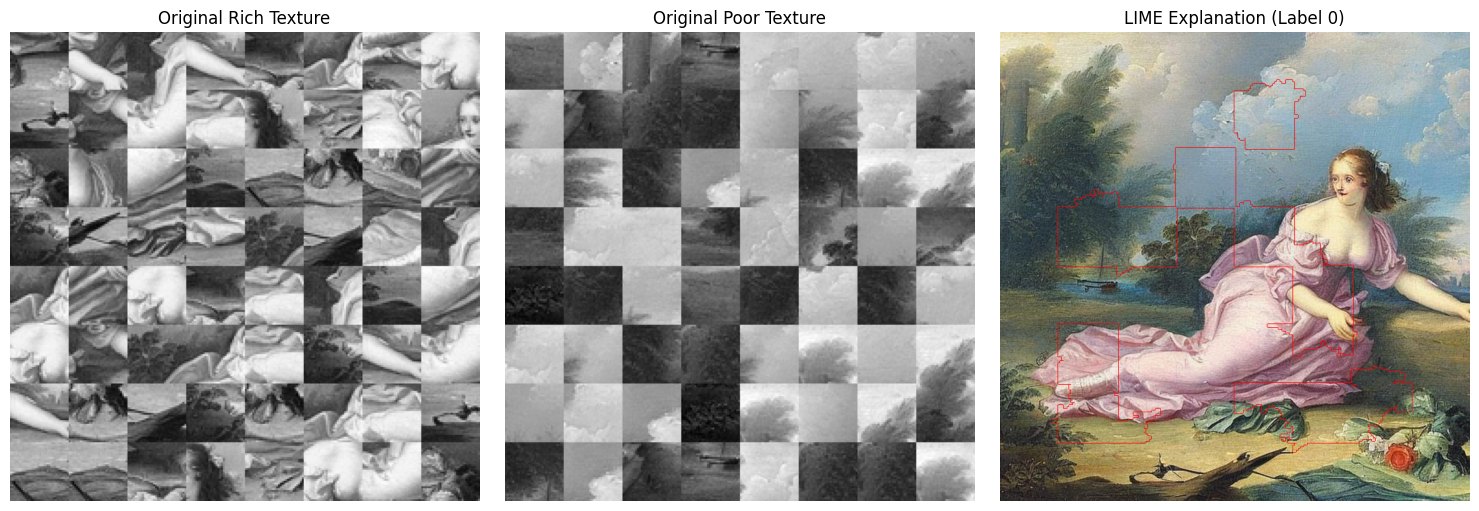

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


In [16]:

# Example model loading (replace 'your_model_path.h5' with actual model path)
model = load_model(r'C:\Users\esull\OneDrive\Documents\ds340_final_attempt\Detection-of-AI-generated-images\checkpoints\model_checkpoint1.keras')

# Example image path (replace 'example_image.jpg' with actual image path)
image_path = r'C:\Users\esull\OneDrive\Documents\ds340_final_attempt\Detection-of-AI-generated-images\data\evaluate\7-101055791-560690_ai.jpg'

# Example usage of the LIME explanation function
label, prediction = explain_prediction_lime(model, image_path)
